
# Learning to Leverage Loyalty
## Jaap Abbring, 30 May 2024

Suppose you are a marketeer in charge of a customer loyalty program. The program houses a finite set ${\cal I}$ of customers. You need to decide on a strategy for mailing them. 

### Marketeer's Problem

For each customer $i\in{\cal I}$, in every week $t=1,2,\ldots$, you make a binary choice $A_{it}$ whether to send her a mail ($A_{it}=1$) or not ($A_{it}=0$) about your product. The cost of sending a mail to customer $i$ is $\gamma_M$ (`cMail`). If customer $i$ is happy enough (which she can be even if you did not email her), she buys your product, you earn $\pi$ (`uBuy`), and she remains loyal. If customer $i$ is somehow annoyed, she may complain, in which case you incur a cost $\gamma_C$ (`cCompl`) and customer $i$ may leave your loyalty program. If she leaves, you spend $\gamma_L$ (`cLeave`) to recruit a new loyal customer that you know to respond similarly (say because she is from the same narrow demographic group) to customer $i$. In fact, because she is so similar to the customer you just lost, you call her $i$ as well, so that you will always have a customer $i$ around. 

The profits from your mailing campaign in a given week $t$ are simply the sum of earnings from buying customers minus the sum of all mailing costs and all costs from complaining and leaving customers in week $t$. You discount future profits with a factor $\rho$ (`rho`). 

In [1]:
cMail = 0.1; % cost of mailing
uBuy = 4; % value of conversion
cCompl = 3; % cost of complaint
cLeave = 5; % cost of recruiting a new loyal customer
rho = 0.9;  % discount factor                 

### Costumer Responses

Customer $i$'s response in week $t$ is fully determined by the week $t$ binary mail decision $A_{it}$ and her two-week mail history $S_{it}=(A_{i(t-1)},A_{i(t-2}))$ (new loyal customers start with $S_{it}=(0,0)$). Specifically, in week $t$, given a mail choice $A_{it}$ and history $S_{it}$, customer $i$'s responses are independent from those of the other customers $j\in{\cal I}/\{i\}$. She buys your good with probability $p_B(A_{it},S_{it})$ (`pBuy`), in which case she does not complain and stays loyal. If she does not buy your good, she complains with probability $p_C(A_{it},S_{it})$ (`pCompl`). Given that she complains, she leaves with probability $p_L(A_{it},S_{it})$ (`pLeave`); otherwise, she stays for sure.

In [2]:
% The marketeer assumes that customers care about mail in t, t-1,.., t-lags
lags = 2; % should be set >= 2

% In fact, customers only care about mail in t, t-1, and t-2.
% Therefore, we first code up the response probabilities 
% by states S\in{00,01,10,11} in columns and
%    actions A\in{0,1} in rows
% so that mailing sequences for the 4x2 entries are
%    000 010 100 110
%    001 011 101 111

pBuy = [0.05 0.10 0.05 0.30; ... 
        0.20 0.40 0.20 0   ];     % probability of conversion
pCompl = [0 0 0 0; ... 
          0 0 0 0.9];             % probability of complaint given lack of conversion
pLeave = 0.9*ones(size(pCompl));  % probability of leaving given complaint

% Then, we repeat the response probability matrices to cover the larger
% state space employed by the marketeer if lags>2.
% In particular, if lags=3, two copies of the response probabilities are
% put side to side to cover the 8x2 mailing sequences
%    0000 0010 0100 0110 1000 1010 1100 1110
%    0001 0011 0101 0111 1001 1011 1101 1111
% Note that the leftmost digit is irrelevant to the customer, but taken along by
% the marketeer in this example with lags=3.

pBuy=repmat(pBuy,1,2^(lags-2))
pCompl=repmat(pCompl,1,2^(lags-2))
pLeave=repmat(pLeave,1,2^(lags-2))


pBuy =

    0.0500    0.1000    0.0500    0.3000
    0.2000    0.4000    0.2000         0


pCompl =

         0         0         0         0
         0         0         0    0.9000


pLeave =

    0.9000    0.9000    0.9000    0.9000
    0.9000    0.9000    0.9000    0.9000



You may or may not (fully) know this model of customers' responses. In particular, you may not know your customers' response probabilities, the fact that they are identical across customers, the various response values, and the history customers respond to (the latter is controlled through `lags` in the above code; see the Food for Thought at the end). If you do not know the customer response model, you will employ reinforcement learning (RL) to optimize your mail campaign. To provide a benchmark for the RL approach, we first analyze the case in which you know the customer response model.

### Benchmarks: (Nearly) Optimal Solutions in a Known Customer Response Environment

#### Optimal Values and Policy

If you _know_ the model that generates the customers' responses, you can optimize your mailing strategy by optimally solving each customer's known, independent mailing problem. 

For customer $i$, the value $U(s,a)$ of mail decision $a$ with (two-period) mail history $s$ in period $t$, measured just after making decision $a$ but before learning about and collecting any resulting payoffs, satisfies the Bellman equation

$$U(s,a)=\mathbb{E}[R_i+\rho\max_{a'}U(S_i',a') | S_i=s,A_i=a],$$
where 
- $R_i=\pi-A_i\gamma_M$ with probability $p_B(A_{i},S_{i})$ (consumer $i$ buys), 
- $R_i=-A_i\gamma_M$ with probability $(1-p_B(A_{i},S_{i}))(1-p_C(A_{i},S_{i}))$ (she neither buys nor complains),
- $R_i=-\gamma_C-A_i\gamma_M$ with probability $(1-p_B(A_{i},S_{i}))p_C(A_{i},S_{i})(1-p_L(A_{i},S_{i}))$ (she complains but stays), and 
- $R_i=-\gamma_C-\gamma_L-A_i\gamma_M$ with probability $(1-p_B(A_{i},S_{i}))p_C(A_{i},S_{i})p_L(A_{i},S_{i})$ (she complains and leaves).

In the first three cases, customer $i$ stays, so $S_i'$ equals $S_i$ updated with $A_i$; in the fourth case, a new customer $i$ is recruited, so $S_i'=(0,0)$.

Here, we suppressed time subscripts and used $S_i'$ to denote next week's value of $S_i$, etcetera. 

Because you know customer $i$'s response model in this case, you can calculate the conditional expectation $\mathbb{E}[\cdot| S_i=s,A_i=a]$ over $R_i$ and $S_i'$ and solve for $U$ by finding the fixed point of the Bellman equation, for which we will use value iteration. With $U$ in hand, the optimal strategy for mailing customer $i$ follows from the actions $a$ that maximize $U(s,a)$ in each state $s$.

In [3]:
tol = 1E-9;
nS = 2^lags % number of states

ER = pBuy*uBuy-(1-pBuy).*pCompl.*(cCompl+pLeave*cLeave)-[0;1]*cMail % expected payoff

% next period's state from current state (col) and choice (row) for remaining customer
newState = bitset(bitshift(0:nS-1,1),lags+1,0);
newState = [newState;bitset(newState,1,1)]
% with lags=2, newState= [0b00 0b10 0b00 0b10; ...
%                         0b01 0b11 0b01 0b11] 

oldU = zeros(2,nS); % choice-specific value ("Q function")
newU = oldU + 2*tol;  
while (max(max(abs(newU-oldU)))>tol)
    oldU=newU;
    maxU=max(oldU);
    newU=ER+(1-(1-pBuy).*pCompl.*pLeave)*rho.*maxU(1+newState)...
              +(1-pBuy).*pCompl.*pLeave*rho*maxU(1);
end
dpU=newU
v=max(dpU)
dpA=(dpU(2,:)>dpU(1,:))


nS =

     4


ER =

    0.2000    0.4000    0.2000    1.2000
    0.7000    1.5000    0.7000   -6.8500


newState =

     0     2     0     2
     1     3     1     3


dpU =

   10.2362   10.4362   10.2362   11.2362
   11.1513   11.6125   11.1513    3.2007


v =

   11.1513   11.6125   11.1513   11.2362


dpA =

  1x4 logical array

   1   1   1   0



Notes:
- We have chosen notation that aligns with the RL literature. In particular, we have denoted the state with $S_i$ instead of $X_i$. We have put the state as the first and the action as the second argument in the choice-specific value  $U(s,a)$, which the RL literature refers to as a _state-action value_. We also use the random _response_ $R_i$ as the flow payoff, whereas we focused on something like $u(a,s)=\mathbb{E}[R_i| S_i=s,A_i=a]$ before.
- We have not subscripted $U$ with $i$, because all customers have the same response probabilities and resulting payoffs, and therefore bring the same choice-specific value to the program. Consequently, you only need to solve the mailing problem once for a typical customer and can subsequently apply the resulting rule to all customers. 
- As long as all customers' response models (and resulting payoffs) are known, you could instead allow them to be heterogeneous and solve a separate mailing decision problem for each customer. 

#### Value of the $\epsilon$-Greedy Policy

The optimal policy in a known customer response environment is a _greedy_ policy: It picks the mail action with the highest choice-specific value. In fact, it is the specific greedy policy that results from maximizing the corresponding _optimal_ value that is the fixed point to the Bellman equation.  

Reinforcement learning is concerned with the case in which the customer response model is not known (or known, but such that the conditional expectation $\mathbb{E}[\cdot| S_i=s,A_i=a]$ is hard to compute). In that case, you need to balance _exploitation_, taking actions that currently seem optimal (as prescribed by a greedy strategy), and _exploration_, taking actions that may not  currently seem optimal to learn more about the value of those actions. An _$\epsilon$-greedy_ policy is a policy that strikes one such balance: It is greedy with probability $1-\epsilon$, but picks an action from a uniform distribution over actions with probability $\epsilon$. 

The choice-specific value $U^\epsilon$ of always applying an $\epsilon$-greedy policy can be calculated recursively from

$$U^\epsilon(s,a)=\mathbb{E}[R_i+\rho\max^\epsilon_{a'}U^\epsilon(S_i',a')| S_i=s,A_i=a],$$
where
$$\max^\epsilon_{a'}U^\epsilon(S_i',a')=(1-\epsilon)\max_{a'}U^\epsilon(S_i',a')+\epsilon \frac{U^\epsilon(S_i',0)+U^\epsilon(S_i',1)}2.$$

Note that this is also the Bellman equation for a version of the mailing problem in which the action is randomized with probability $\epsilon$, so that $U^\epsilon$ is the optimal choice-specific value given such randomization.

In [4]:
epsilon = 0.2 % exploration probability for epsilon-greedy policies 

oldU = zeros(2,nS);
newU = oldU + 2*tol; 
while (max(max(abs(newU-oldU)))>tol)
    oldU=newU;
    maxU=(1-epsilon)*max(oldU)+epsilon*[1/2 1/2]*oldU;
    newU=ER+(1-(1-pBuy).*pCompl.*pLeave)*rho.*maxU(1+newState)...
              +(1-pBuy).*pCompl.*pLeave*rho*maxU(1);
end
Ueps=newU
maxUeps=max(Ueps)
veps=(1-epsilon)*maxUeps+epsilon*[1/2 1/2]*Ueps
Aeps=(Ueps(2,:)>Ueps(1,:))

max(max(abs(dpU-Ueps)))


epsilon =

    0.2000


Ueps =

    7.6091    7.8091    7.6091    8.6091
    8.3016    8.5170    8.3016    0.4846


maxUeps =

    8.3016    8.5170    8.3016    8.6091


veps =

    8.2323    8.4462    8.2323    7.7966


Aeps =

  1x4 logical array

   1   1   1   0


ans =

    3.0956



### Reinforcement Learning in a Unknown Customer Response Environment

Now suppose you do _not_ know the customers' response model and need to learn it from interaction with the customers. 

First suppose you wish to allow for arbitary differences between your loyal customers. In this case, you can only learn about customer $i\in{\cal I}$ from your experience with customer $i$ herself. We will discuss two basic RL algorithms for learning from the time series of interactions with customer $i$, SARSA and Q-learning (see Chapter 6 in Sutton and Barto, 2020). 

#### SARSA

SARSA is an _on-policy_ RL method. This means it uses the same policy for taking actions and for calculating updates to the value function. To ensure that sufficient exploration takes place, we use an $\epsilon$-greedy policy based on the current iteration of the choice-specific (in RL, _state-action_) value.

Our version of SARSA starts by arbitrarily initializing $Q_1$, initializing $S_1=(0,0)$ (if `lags` is set to 2), and drawing an initial action $A_1$ using the $\epsilon$-greedy policy based on $Q_1(S_1,\cdot)$. Then, for $t=1,..,\check{t}$, it repeats the following steps:
- draw a response $R_t$ and state $S_{t+1}$;
- draw an action $A_{t+1}$ using the $\epsilon$-greedy policy based on $Q_t(S_{t+1},\cdot)$; and
- update $Q_{t+1}(S_t,A_t)=Q_t(S_t,A_t)+\alpha_t\left[R_t+\rho Q_t(S_{t+1},A_{t+1})-Q_t(S_t,A_t)\right]$.

Here, $\alpha_t\in(0,1]$ is the _learning rate_, which may vary with $t$. Note that we have suppressed the customer subscript $i$ throughout, because all variables _and_ state-action values are now $i$-specific. 

SARSA is an example of _temporal-difference learning_. Like dynamic programming, it updates customer $i$'s choice-specific (state-action) values using their current values to evaluate next period's actions and states. Unlike dynamic programming, it does not take expectations over next period's state, but updates based on a draw from next period's state and action. 

The learning rate $\alpha_t$ determines how much weight is given to new draws $R_t,S_{t+1},A_{t+1}$ relative to the information already accumulated in $Q_t$. In a (known to be) stationary environment like ours, one typically requires that $\alpha_t$ decreases slowly enough for sufficient learning to take place, $\sum_{t=1}^{\infty} \alpha_t = \infty$, but quick enough for sampling noise to eventually be dampened, $\sum_{t=1}^{\infty} \alpha_t^2 < \infty$. A rate like $\alpha_t=1/t$ satisfies these requirements and loosely corresponds to taking sample averages over time. 

Intuitively (this is beyond the current scope of this notebook), with such a learning rate, but a fixed exploration probability $\epsilon$, SARSA converges almost surely to the $\epsilon$-greedy state-action value and policy. 

In [5]:
rng(230670); 
tcheck =100000; % number of periods
alpha = 0.9; % stepsize
newQ = dpU*0; % choice-specific ("state-action") value is denoted with Q in RL literature

distSQ=NaN(1,tcheck);
distSQeps=NaN(1,tcheck);
countSS=zeros(1,nS);

S = 0b00; % start with fresh customer: X=00
greedy = rand>epsilon;
A = greedy*(newQ(2,1+S)>newQ(1,1+S))+(1-greedy)*(rand>0.5);
for t=1:tcheck 
    countSS=countSS+((0:nS-1)==S);
    oldQ=newQ;
    buy = pBuy(1+A,1+S)>rand;
    compl = (1-buy)*(pCompl(1+A,1+S)>rand);
    leave = compl*(pLeave(1+A,1+S)>rand);
    R = buy*uBuy-compl*cCompl-leave*cLeave-A*cMail;
    Sprime = (1-leave)*newState(1+A,1+S); % +leave*0: New customer at X=00 after leaving
    greedy = rand>epsilon;
    Aprime = greedy*(oldQ(2,1+Sprime)>oldQ(1,1+Sprime))+(1-greedy)*(rand>0.5);
    newQ(1+A,1+S) = oldQ(1+A,1+S)+(alpha/(1+(t-1)/1000))*(R+rho*oldQ(1+Aprime,1+Sprime)-oldQ(1+A,1+S));
    S=Sprime;
    A=Aprime;
    distSQeps(t)=max(max(abs(Ueps-newQ)));
    distSQ(t)=max(max(abs(dpU-newQ)));
end
countSS
sum(countSS)
newQ
Ueps
dpU


countSS =

        6893       33332       31069       28706


ans =

      100000


newQ =

    7.6701    7.7883    7.6045    8.6472
    8.3051    8.5167    8.2282    0.4699


Ueps =

    7.6091    7.8091    7.6091    8.6091
    8.3016    8.5170    8.3016    0.4846


dpU =

   10.2362   10.4362   10.2362   11.2362
   11.1513   11.6125   11.1513    3.2007



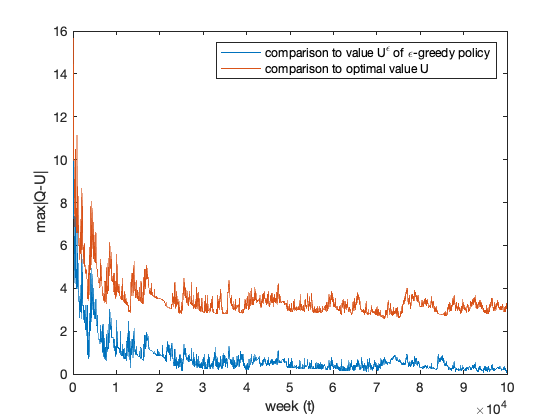

In [6]:
plot(1:size(distSQ,2),[distSQeps;distSQ])
xlabel("week (t)")
ylabel("max|Q-U|")
legend("comparison to value U^\epsilon of \epsilon-greedy policy","comparison to optimal value U")

Because SARSA is an on-policy method and employs (in our case) an $\epsilon$-greedy policy, convergence to the optimal value and policy requires that, in addition to a suitably decreasing learning rate, the exploration probability $\epsilon$ decreases to zero at an appropriate rate. You can try this yourself by amending the above code (in my experience, this requires very careful tailoring of the learning rate and exploration probability). Instead, we will explore an alternative RL method, Q-learning.

#### Q-Learning

Q-learning is an _off-policy_ RL method: It uses different policies for drawing actions and updating state-action values. In our implementation, it explores the customer's responses with $\epsilon$-greedy actions and uses the greedy policy to update values. 

Our version of Q-learning starts by arbitrarily initializing $Q_1$ and initializing $S_1=(0,0)$ (if `lags` is set to 2). Then, for $t=1,..,\check{t}$, it repeats the following steps:
- draw an action $A_t$ using the $\epsilon$-greedy policy based on $Q_t(S_t,\cdot)$;
- draw a response $R_t$ and state $S_{t+1}$; and
- update $Q_{t+1}(S_t,A_t)=Q_t(S_t,A_t)+\alpha_t\left[R_t+\rho \max_{a'}Q_t(S_{t+1},a')-Q_t(S_t,A_t)\right]$.

Q-learning is another example of temporal-difference learning. Intuitively, under the conditions on the learning rate from SARSA, the state-action value $Q_t$ converges almost surely to the optimal one. Of course, you would need to limit your exploration as time goes by to benefit from this. 

In [7]:
rng(230670); 
tcheck =100000; % number of periods
alpha = 0.9; % stepsize
newQ = dpU*0; % choice-specific ("state-action") value is denoted with Q in RL literature

distQQeps=NaN(1,tcheck);
distQQ=NaN(1,tcheck);
countQQ=zeros(1,nS);

S = 0b00; % start with fresh customer: X=00
for t=1:tcheck
    countQQ=countQQ+((0:nS-1)==S);
    oldQ=newQ;
    greedy = rand>epsilon;
    A = greedy*(oldQ(2,1+S)>oldQ(1,1+S))+(1-greedy)*(rand>0.5);
    buy = pBuy(1+A,1+S)>rand;
    compl = (1-buy)*(pCompl(1+A,1+S)>rand);
    leave = compl*(pLeave(1+A,1+S)>rand);
    R = buy*uBuy-compl*cCompl-leave*cLeave-A*cMail;
    Sprime = (1-leave)*newState(1+A,1+S); % +leave*0: New customer at X=00 after leaving
    newQ(1+A,1+S) = oldQ(1+A,1+S)+(alpha/(1+(t-1)/500))*(R+rho*max(oldQ(:,1+Sprime))-oldQ(1+A,1+S));
    S=Sprime;
    distQQeps(t)=max(max(abs(Ueps-newQ)));
    distQQ(t)=max(max(abs(dpU-newQ)));
end
countQQ
sum(countQQ)
newQ
Ueps


countQQ =

        6350       32953       30568       30129


ans =

      100000


newQ =

   10.2991   10.3466   10.2378   11.1415
   11.1324   11.4376   10.9864    3.2132


Ueps =

    7.6091    7.8091    7.6091    8.6091
    8.3016    8.5170    8.3016    0.4846



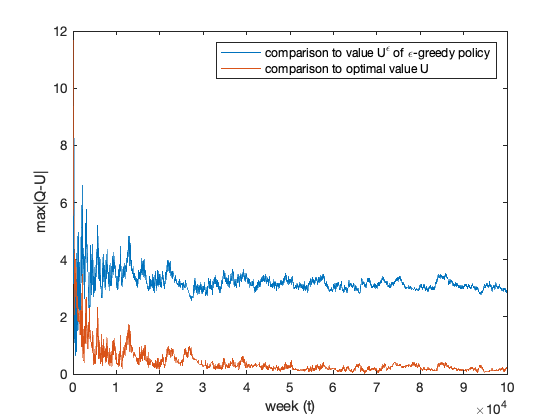

In [8]:
plot(1:size(distQQ,2),[distQQeps;distQQ])
xlabel("week (t)")
ylabel("max|Q-U|")
legend("comparison to value U^\epsilon of \epsilon-greedy policy","comparison to optimal value U")

#### Batch Q-Learning

So far, we assumed that your customers are all different, so that you cannot learn across customers. In this case, you need many weeks of experience with each individual customer.

Now suppose that you know that all your customers have the same response model (for example, because ${\cal I}$ is a subset of your loyal customers with similar characteristics). In this case, each week, you can pool your experiences with all customers in ${\cal I}$ to update a common state-action value for all customers. There are many different ways of pooling your experiences this way. We will simply adapt the Q-learning algorithm for a single customer so that, each week, it sequentially adapts the state-action value with the data from each customer. As we will need to iterate both over time and over customers, we reintroduce the customer subscript $i$ and take ${\cal I}=\{1,2,\ldots,\check{n}\}$.

Our version of _(multi-)batch Q-learning_ starts by arbitrarily initializing $Q_1$ and, for all $i\in{\cal I}$, initializing $S_{i1}=(0,0)$ (if `lags` is set to 2). Then, for $t=1,..,\check{t}$, it repeats the following steps:
- for $i\in{\cal I}$ (in no particular order), draw actions $A_{it}$ using the $\epsilon$-greedy policy based on $Q_t(S_{it},\cdot)$;
- initialize $Q_{0t}=Q_t$;
- for $i=1,\ldots,\check{n}$ (in this particular order), draw a response $R_{it}$ and state $S_{i(t+1)}$; and update $$Q_{it}(S_{it},A_{it})=Q_{(i-1)t}(S_{it},A_{it})+\alpha_t\left[R_{it}+\rho \max_{a'}Q_{(i-1)t}(S_{i(t+1)},a')-Q_{(i-1)t}(S_{it},A_{it})\right];$$ 
- set $Q_{t+1}=Q_{\check{n}t}$.

The key difference with standard Q-learning over time for a single customer is that actions are not drawn before each update of the state-choice value, but in batch for all customers based on the value $Q_t$ in memory at the start of each week $t$.

Under the now standard conditions on the learning rate, we again have almost sure convergence of the state-action value $Q_t$. We will see that convergence is way faster, to the point it may actually be practically useful in your marketing campaign, now that we can pool information across costumers this way.

In [9]:
rng(230670); 
tcheck =104; % number of periods
ncheck =10000; % stock of loyal customers
alpha = 0.1; % initial learning rate
newQ = dpU*0; % choice-specific ("state-action") value is denoted with Q in RL literature

distBQeps=NaN(1,tcheck);
distBQ=NaN(1,tcheck);
countBQ=zeros(1,nS);

S = zeros(1,ncheck); % each customer starts fresh: X=00
for t=1:tcheck
    greedy = rand(1,ncheck)>epsilon;
    A = greedy.*(newQ(2,1+S)>newQ(1,1+S))+(1-greedy).*(rand(1,ncheck)>0.5);
    for n=1:ncheck
        countBQ=countBQ+((0:nS-1)==S(n));
        oldQ=newQ;
        buy = pBuy(1+A(n),1+S(n))>rand;
        compl = pCompl(1+A(n),1+S(n))>rand;
        leave = compl*(pLeave(1+A(n),1+S(n))>rand);
        R = buy*uBuy-compl*cCompl-leave*cLeave-A(n)*cMail;
        Sprime = (1-leave)*newState(1+A(n),1+S(n)); % +leave*0: New customer at X=00 after leaving
        newQ(1+A(n),1+S(n)) = oldQ(1+A(n),1+S(n))+(alpha/t)*(R+rho*max(oldQ(:,1+Sprime))-oldQ(1+A(n),1+S(n)));
        S(n)=Sprime;
    end
    distBQeps(t)=max(max(abs(Ueps-newQ)));
    distBQ(t)=max(max(abs(dpU-newQ)));
 end
countBQ
sum(countBQ)
newQ
dpU
Ueps


countBQ =

       96922      335126      304447      303505


ans =

     1040000


newQ =

   10.2522   10.4453   10.2281   11.1468
   11.1282   11.4961   11.0218    3.2028


dpU =

   10.2362   10.4362   10.2362   11.2362
   11.1513   11.6125   11.1513    3.2007


Ueps =

    7.6091    7.8091    7.6091    8.6091
    8.3016    8.5170    8.3016    0.4846



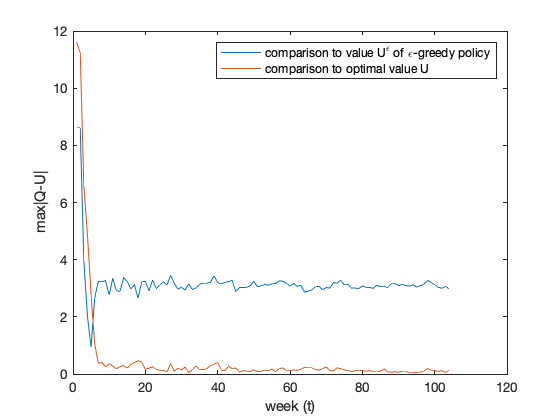

In [10]:
plot(1:size(distBQ,2),[distBQeps;distBQ])
xlabel("week (t)")
ylabel("max|Q-U|")
legend("comparison to value U^\epsilon of \epsilon-greedy policy","comparison to optimal value U")

### Food for Thought
#### Practical Issues
The RL literature is very hands on, focused on algorithms and their practical implementation. There are many different ways of implementing the various RL methods. 

#### Unknown State Space and Performance
If you set `lags` equal to 2, you are effectively assuming you know what mail history matters nontrivially to customers. In practice, you may not know. Then, to err on the safe side, you may want to learn state-action values and policies on a comparatively rich state space; you would then hope and expect to eventually learn that parts of the state are irrelevant to the state-action values and optimal mail policy. You can experiment a bit with this by setting `lags` to an integer larger than 2, which keeps the same true two-week lag response model, but adds additional, irrelevant lags to the state. 

#### Learning in a Changing Environment
In practice, you may not be so confident that the consumer response environment is stationary. If it is not, enforcing convergence of RL by choosing a learning rate that falls to zero at an appropriate rate may not be so wise. Instead, you could for example pick a fixed rate $\alpha_t=\alpha$ for continued updating based on recent experiences (of course, you can easily adapt the above code to try this).

#### Optimal Learning
In my experience, the performance of the simple RL approaches in this notebook are quite sensitive to your choice of exploration and learning rates. This makes one wonder what the _best_ settings for these rates are from your perspective as a marketeer. There is a large literature on such _optimal_ learning, which is beyond the current scope of this notebook.

#### RL as a Solution Method in a Known Environment
We have introduced RL as a practical way to optimize your mail strategy if you not know the customer response environment, so that you do not _a priori_ know the conditional expectation $\mathbb{E}[\cdot| S_i=s,A_i=a]$ over $R_i$ and $S_i'$ that you need to solve the Bellman equation. RL can also be used to solve Markov decision problems sequentially through simulation if you know the customer response environment but cannot easily _calculate_  $\mathbb{E}[\cdot| S_i=s,A_i=a]$, for example because the state space is very large. 

#### RL as an Empirical Model of Individual Behavior
In economic theory and structural econometrics, it is often assumed that agents solve Markov decision problems in an environment that they know (but the econometrician may need to learn about) through dynamic programming. In settings with strategic interactions, they are often assumed to do so in Markov perfect equilibrium. 

Similarly, one may assume that agents in a data set are Q-learners. This has for example been applied in the analysis of collusive behavior. 

Exploration in itself already provides a source of econometric error in an econometric model with Q-learning agents. In such a setting, instead of an $\epsilon$-greedy policy, one may prefer to assume agents employ a _softmax_ policy, which specifies

$$\Pr(A_t=a|S_t=s)=\frac{\exp(\xi Q_t(s,a))}{\sum_{a'\in{\cal A}}\exp(\xi Q_t(s,a'))},$$

where ${\cal A}$ may be $\{0,1\}$, as in our mailing example, or be a larger finite choice set. Here, $\xi>0$ is a smoothing parameter: As $\xi\downarrow 0$, $\Pr(A_t=a|S_t=s)$ converges to a uniform (across $a\in{\cal A}$) distribution; as $\xi\rightarrow\infty$, the softmax policy turns greedy based on $Q_t$. 

Of course, this is simply the multinomial logit model with a free scale parameter $\xi$ (see the optional slides on "Smoothing, Newton's Method, and Policy Iteration"). As in the dynamic programming case, this can be interpreted in terms of agents maximizing the stochastic utility $Q_t(S_t,a)+\varepsilon_t(a)$ over $a$, with the utility shocks $\varepsilon_t(a)$ independently Gumbel distributed with scale parameter $\xi$ (and not to be confused with the exploration probability $\epsilon$). However, unlike in the dynamic programming case, in Q-learning these utility shocks only play a role in drawing actions, not in updating the choice-specific (state-action) values. 

### References

-	Sutton, R.S, and A.G. Barto (2020): _Reinforcement Learning: An Introduction_, Second edition, Cambridge: MIT Press. http://incompleteideas.net/book/RLbook2020.pdf 